In [12]:
import sys
sys.path.append('../')
sys.path.append('../../../')
import numpy as np
import pandas as pd
import cv2
import libs.normalization as normalization
import models
import keras
import libs.analysis as analysis
import libs.render as render
from keras.models import load_model
from importlib import reload
import matplotlib.pyplot as plt
%matplotlib inline
reload(models)

<module 'models' from '../models.py'>

In [3]:
# Data Preparation
import glob
import cv2
import os

# 0 = He, 1 = Le, 2 = IPCL, 3 = Hbv
labels = [0,1,2,3]
patch_size = 101

# He = healthy
# Le = Leukoplakia
# IPCL = intraepithelial papillary capillarry loops
# Hbv = hypertrophic blood vessels
he = glob.glob('../laryngeal_dataset/*/He/*.png')
le = glob.glob('../laryngeal_dataset/*/Le/*.png')
ipcl = glob.glob('../laryngeal_dataset/*/IPCL/*.png')
hbv = glob.glob('../laryngeal_dataset/*/Hbv/*.png')

def read_data(data, label_id, patch_size):
    size = len(data)
    images = np.zeros((size, patch_size, patch_size, 3), dtype=np.float32)
    labels = np.zeros(size, dtype=np.int64)
    target_shape = (patch_size, patch_size, 3)
    
    for idx in range(size):
        img = cv2.imread(os.path.join(data[idx]))
        if img.shape != target_shape:
            img = cv2.resize(img, (target_shape[0], target_shape[1]))
        images[idx] = img
        labels[idx] = label_id
        
    return images, labels

he_images, he_labels = read_data(he, 0, patch_size)
le_images, le_labels = read_data(le, 1, patch_size)
ipcl_images, ipcl_labels = read_data(ipcl, 2, patch_size)
hbv_images, hbv_labels = read_data(hbv, 3, patch_size)

In [4]:
print(he_images.shape)
print(le_images.shape)
print(ipcl_images.shape)
print(hbv_images.shape)

(330, 101, 101, 3)
(330, 101, 101, 3)
(330, 101, 101, 3)
(330, 101, 101, 3)


In [5]:
# SPLIT: Train / Test / Validation
from sklearn.model_selection import train_test_split

# merge the images and labels
x_data = np.concatenate((he_images, le_images, ipcl_images, hbv_images), axis=0)
y_data = np.concatenate((he_labels, le_labels, ipcl_labels, hbv_labels), axis=0)
print(x_data.shape, y_data.shape)

x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

(1320, 101, 101, 3) (1320,)


In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(924, 101, 101, 3)
(924,)
(198, 101, 101, 3)
(198,)
(198, 101, 101, 3)
(198,)


In [7]:
## Normalization
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_val = x_val.astype(np.float32)

m , std = normalization.dataset_mean_and_std(x_train)

x_train_norm = (x_train - m) / std
x_test_norm = (x_test - m) / std
x_val_norm = (x_val - m) / std

num_classes = 4
y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_test_oh = keras.utils.to_categorical(y_test, num_classes)
y_val_oh = keras.utils.to_categorical(y_val, num_classes)

In [47]:
# OPTIONALY: LOAD MODEL
model_name = 'model_validation_run_001.h5'
#load_model(model_name)

In [44]:
reload(models)
model = models.run_deep_dropout()
display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = models.optimizer(), loss = "categorical_crossentropy", 
              metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 101, 101, 32)      896       
_________________________________________________________________
activation_36 (Activation)   (None, 101, 101, 32)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 101, 101, 32)      9248      
_________________________________________________________________
activation_37 (Activation)   (None, 101, 101, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 50, 50, 64)        18496     
__________

None

In [51]:
# parameters
batch_size = 64
epochs = 30

history = model.fit(x_train_norm, y_train_oh, batch_size=batch_size,
                              epochs = epochs,
                              validation_data = (x_test_norm,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[models.annealer()])

Train on 924 samples, validate on 198 samples
Epoch 1/30
924/924 [==============================] - 2s 2ms/step - loss: 0.1042 - acc: 0.9491 - val_loss: 0.4813 - val_acc: 0.8586
Epoch 2/30
924/924 [==============================] - 2s 2ms/step - loss: 0.0895 - acc: 0.9600 - val_loss: 0.5130 - val_acc: 0.8434
Epoch 3/30
924/924 [==============================] - 2s 2ms/step - loss: 0.0911 - acc: 0.9610 - val_loss: 0.5197 - val_acc: 0.8636
Epoch 4/30
924/924 [==============================] - 2s 2ms/step - loss: 0.0776 - acc: 0.9686 - val_loss: 0.5544 - val_acc: 0.8737
Epoch 5/30
924/924 [==============================] - 2s 2ms/step - loss: 0.0659 - acc: 0.9740 - val_loss: 0.5516 - val_acc: 0.8586
Epoch 6/30
924/924 [==============================] - 2s 2ms/step - loss: 0.0994 - acc: 0.9632 - val_loss: 0.5492 - val_acc: 0.8687
Epoch 7/30
924/924 [==============================] - 2s 2ms/step - loss: 0.0545 - acc: 0.9740 - val_loss: 0.5885 - val_acc: 0.8838
Epoch 8/30
924/924 [==========

In [52]:
model.save(model_name)

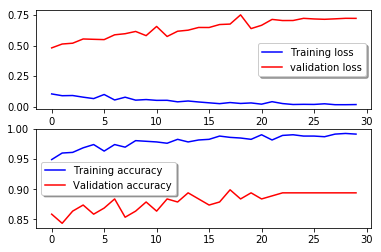

Precision (specificity): 88.428%
Recall (sensitivity): 88.488%
Accuracy: 89.394%
F1: 88.416%


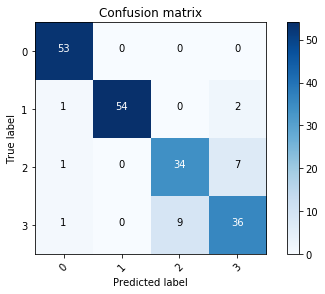

In [53]:
## ANALYZE THE FIRST RUN
import libs.analysis as analysis
import libs.render as render

render.plot_training_and_validation_curves(history)

y_pred_oh = model.predict(x_val_norm)

cm = render.setup_confusion_matrix(y_pred_oh, x_val_norm, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=4)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [56]:
## Now Let's do a run with data augmentation
from keras.preprocessing.image import ImageDataGenerator

epochs2 = 30
batch_size2 = 64 

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=45,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2,                     # Randomly zoom image 
        width_shift_range=0.15,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                  # randomly flip images


datagen.fit(x_train_norm)


history2 = model.fit_generator(datagen.flow(x_train_norm,y_train_oh, batch_size=batch_size2),
                              epochs = epochs2, validation_data = (x_test_norm,y_test_oh),
                              workers = 4,
                              verbose = 1, steps_per_epoch = x_train_norm.shape[0] # batch_size
                              , callbacks=[models.annealer()])

Epoch 1/30
924/924 [==============================] - 110s 119ms/step - loss: 0.4686 - acc: 0.8372 - val_loss: 0.2581 - val_acc: 0.8889
Epoch 2/30
924/924 [==============================] - 110s 119ms/step - loss: 0.3202 - acc: 0.8612 - val_loss: 0.2342 - val_acc: 0.9040
Epoch 3/30
924/924 [==============================] - 109s 118ms/step - loss: 0.2802 - acc: 0.8801 - val_loss: 0.2302 - val_acc: 0.9091
Epoch 4/30
924/924 [==============================] - 110s 120ms/step - loss: 0.2469 - acc: 0.8955 - val_loss: 0.2109 - val_acc: 0.9141
Epoch 5/30
924/924 [==============================] - 111s 120ms/step - loss: 0.2195 - acc: 0.9101 - val_loss: 0.2164 - val_acc: 0.9141
Epoch 6/30
924/924 [==============================] - 110s 119ms/step - loss: 0.2011 - acc: 0.9191 - val_loss: 0.1969 - val_acc: 0.9192
Epoch 7/30
924/924 [==============================] - 110s 119ms/step - loss: 0.1777 - acc: 0.9295 - val_loss: 0.1728 - val_acc: 0.9293
Epoch 8/30
924/924 [============================

In [57]:
model_name2 = 'model_validation_run_001_v2.h5'
model.save(model_name2)

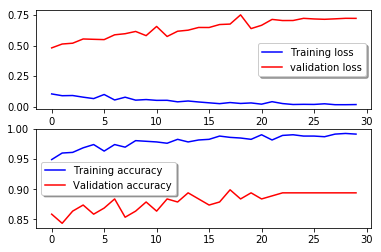

Precision (specificity): 94.959%
Recall (sensitivity): 95.007%
Accuracy: 95.455%
F1: 94.978%


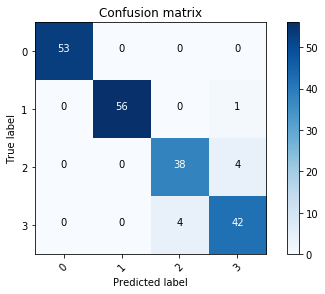

In [58]:
## ANALYZE THE FIRST RUN
import libs.analysis as analysis
import libs.render as render

render.plot_training_and_validation_curves(history)

y_pred_oh = model.predict(x_val_norm)

cm = render.setup_confusion_matrix(y_pred_oh, x_val_norm, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=4)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [8]:
## FIXES: 
model = load_model('model_validation_run_001_v2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 101, 101, 32)      896       
_________________________________________________________________
activation_36 (Activation)   (None, 101, 101, 32)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 101, 101, 32)      9248      
_________________________________________________________________
activation_37 (Activation)   (None, 101, 101, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 50, 50, 64)        18496     
__________

In [18]:
reload(analysis)
reload(render)
from pylab import rcParams
rcParams['figure.figsize'] = (8, 8) # constant figure size

Precision (specificity): 94.959%
Recall (sensitivity): 95.007%
Accuracy: 95.455%
F1: 94.978%


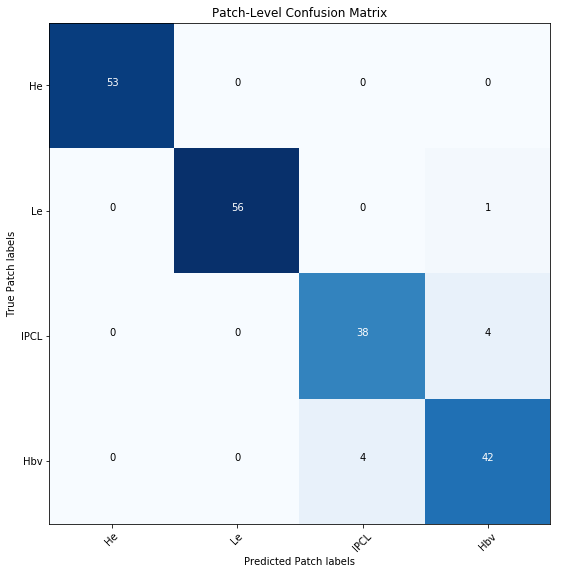

In [17]:
## ANALYZE THE FIRST RUN
import libs.analysis as analysis
import libs.render as render

#render.plot_training_and_validation_curves(history)

y_pred_oh = model.predict(x_val_norm)

cm = render.setup_confusion_matrix(y_pred_oh, x_val_norm, y_val_oh)

render.plot_confusion_matrix_fix(cm, num_classes=4, labels=['He', 'Le', 'IPCL', 'Hbv'], save='v7_cm')

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)